In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [20]:
all_out = glob("out/**/*.pkl")

In [21]:
all_out = [load_pickle(p) for p in all_out]

In [22]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "target": out["target"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["xgb_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["xgb_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["xgb_metrics"]["f1_micro"],
        "kappa": out["baseline"]["xgb_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    
    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["tabpfn_metrics"]["f1_micro"],
        "kappa": out["baseline"]["tabpfn_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    xgboost_results.append(xgb_res)
    if out["baseline"]["tabpfn_metrics"]["accuracy"] >0:
        tabpfn_results.append(tabpfn_res)

In [25]:
out

{'train_size': 10,
 'num_classes': 2,
 'target': ('logKH_CO2', 'CO2 Henry coefficient'),
 'baseline': {'xgb_predictions': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
  'tabpfn_prediction

In [7]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [8]:
res

,train_size,frac_valid,accuracy,f1_macro,f1_micro,kappa,num_classes,target
0,10,1.0,0.228,0.155294,0.228,0.035,5,"(logKH_CH4, CH4 Henry coefficient)"
1,20,0.0,0.000,0.000000,0.000,0.000,5,"(logKH_CH4, CH4 Henry coefficient)"
2,20,1.0,0.508,0.507614,0.508,0.016,2,"(logKH_CH4, CH4 Henry coefficient)"
3,100,1.0,0.568,0.567557,0.568,0.136,2,"(logKH_CH4, CH4 Henry coefficient)"
4,10,1.0,0.556,0.514614,0.556,0.112,2,"(logKH_CO2, CO2 Henry coefficient)"
...,...,...,...,...,...,...,...,...
67,10,1.0,0.472,0.467879,0.472,-0.056,2,"(logKH_CH4, CH4 Henry coefficient)"
68,20,1.0,0.200,0.184236,0.200,0.000,5,"(logKH_CO2, CO2 Henry coefficient)"
69,20,1.0,0.488,0.486389,0.488,-0.024,2,"(logKH_CO2, CO2 Henry coefficient)"
70,200,1.0,0.316,0.310068,0.316,0.145,5,"(logKH_CH4, CH4 Henry coefficient)"


In [9]:
grouped_res = res.groupby(["num_classes", "target", "train_size"]).agg(["mean", "std", sem])

In [10]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

In [11]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

In [12]:
grouped_res.loc[2, :]

frac_valid                      \
                                                    mean       std       sem   
target                             train_size                                  
(logKH_CH4, CH4 Henry coefficient) 10           0.777778  0.440959  0.146986   
                                   20           0.600000  0.547723  0.244949   
                                   50           0.750000  0.500000  0.250000   
                                   100          1.000000  0.000000  0.000000   
                                   200          1.000000  0.000000  0.000000   
                                   500          1.000000       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10           0.777778  0.440959  0.146986   
                                   20           0.600000  0.547723  0.244949   
                                   50           0.666667  0.577350  0.333333   
                                   100          1.000000       NaN       NaN   
                                   200          1.000000  0.000000  0.000000   

                                               accuracy                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.411111  0.235421  0.078474   
                                   20          0.324000  0.297281  0.132948   
                                   50          0.408000  0.272235  0.136118   
                                   100         0.572000  0.005657  0.004000   
                                   200         0.548000  0.045255  0.032000   
                                   500         0.624000       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10          0.401778  0.229862  0.076621   
                                   20          0.304800  0.278545  0.124569   
                                   50          0.364000  0.316000  0.182443   
                                   100         0.500000       NaN       NaN   
                                   200         0.574000  0.008485  0.006000   

                                               f1_macro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.380077  0.225056  0.075019   
                                   20          0.319954  0.293052  0.131057   
                                   50          0.407012  0.271563  0.135781   
                                   100         0.571765  0.005951  0.004208   
                                   200         0.547258  0.045533  0.032197   
                                   500         0.623132       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10          0.389278  0.222449  0.074150   
                                   20          0.298556  0.272678  0.121945   
                                   50          0.363961  0.315962  0.182421   
                                   100         0.497677       NaN       NaN   
                                   200         0.572803  0.007419  0.005246   

                                               f1_micro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.411111  0.235421  0.078474   
                                   20          0.324000  0.297281  0.132948   
                                   50          0.408000  0.272235  0.136118   
                                   100         0.572000  0.005657  0.004000   
                                   200         0.548000  0.045255  0.032000   
                                   500         0.624000       NaN       NaN   


In [13]:
grouped_xgboost_res

accuracy            \
                                                               mean       std   
num_classes target                             train_size                       
2           (logKH_CH4, CH4 Henry coefficient) 10          0.504000  0.012000   
                                               20          0.561600  0.088931   
                                               50          0.607000  0.097400   
                                               100         0.718000  0.036770   
                                               200         0.748000  0.033941   
                                               500         0.792000       NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.511556  0.034667   
                                               20          0.593600  0.081761   
                                               50          0.613333  0.053267   
                                               100         0.584000       NaN   
                                               200         0.672000  0.050912   
5           (logKH_CH4, CH4 Henry coefficient) 10          0.200000  0.000000   
                                               20          0.282667  0.043057   
                                               50          0.336000  0.032496   
                                               100         0.388000  0.022627   
                                               200         0.436000  0.016971   
                                               500         0.518000  0.031113   
            (logKH_CO2, CO2 Henry coefficient) 10          0.200000  0.000000   
                                               20          0.208000  0.011314   
                                               50          0.272000       NaN   
                                               200         0.312000  0.039598   
                                               500         0.392000  0.056569   

                                                                         \
                                                                    sem   
num_classes target                             train_size                 
2           (logKH_CH4, CH4 Henry coefficient) 10          4.000000e-03   
                                               20          3.977135e-02   
                                               50          4.869976e-02   
                                               100         2.600000e-02   
                                               200         2.400000e-02   
                                               500                  NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          1.155556e-02   
                                               20          3.656446e-02   
                                               50          3.075350e-02   
                                               100                  NaN   
                                               200         3.600000e-02   
5           (logKH_CH4, CH4 Henry coefficient) 10          1.962616e-17   
                                               20          1.757776e-02   
                                               50          1.453272e-02   
                                               100         1.600000e-02   
                                               200         1.200000e-02   
                                               500         2.200000e-02   
            (logKH_CO2, CO2 Henry coefficient) 10          0.000000e+00   
                                               20          8.000000e-03   
                                               50                   NaN   
                                               200         2.800000e-02   
                                               500         4.000000e-02   

                                                           f1_macro            \
                                                               mean       st

In [14]:
grouped_res.loc[2, :].index[0][0]

('logKH_CH4', 'CH4 Henry coefficient')

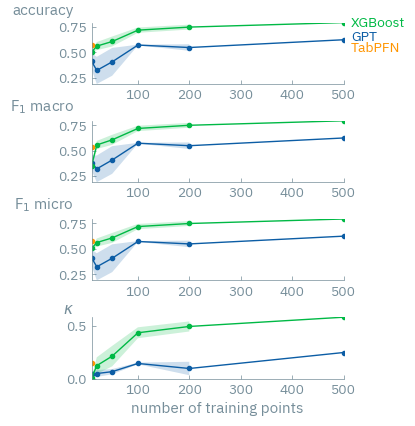

In [18]:

fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    # range_frame(
    #     ax[i],
    #    grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index, 
    #    np.stack(
    #     [
    #     grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
    #      grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
    #         grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
    #     ]
    #    ).flatten()
    # )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)
fig.savefig("logKHCH4-classification_results_binary.pdf", bbox_inches="tight")

In [16]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 10

1.1506806383930557

In [16]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 10

0.8377760469418745

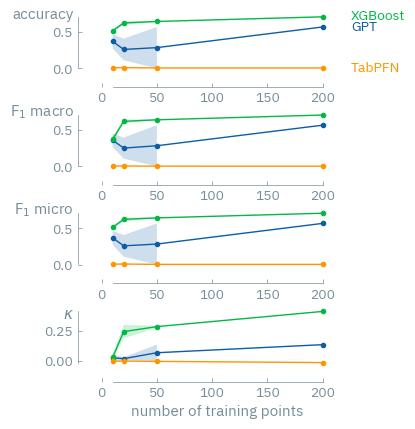

In [17]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
       grouped_res.loc[2, ("logKH_CO2",  "CO2 Henry coefficient"), :].index, 
       np.stack(
        [
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
         grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        ]
       ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("logKHCO2-classification_results_binary.pdf", bbox_inches="tight")

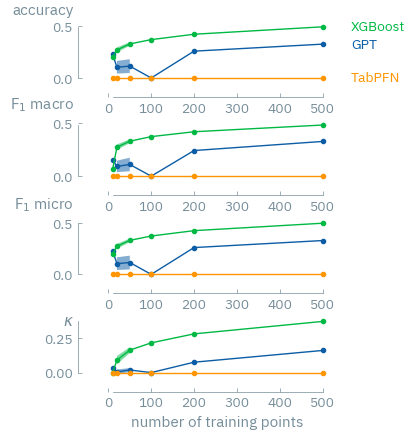

In [18]:

fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )
    range_frame(
        ax[i],
       grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index, 
       np.stack(
        [
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
         grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        ]
       ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("logKHCH4-classification_results_5.pdf", bbox_inches="tight")